In [1]:
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(useful)) 
suppressPackageStartupMessages(library(ggplot2)) 
suppressPackageStartupMessages(library(dplyr)) 
suppressPackageStartupMessages(library(limma)) 
suppressPackageStartupMessages(library(EnhancedVolcano)) 
suppressPackageStartupMessages(library(biomaRt)) 
suppressPackageStartupMessages(library(gridExtra)) 
suppressPackageStartupMessages(library(repr)) 

Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired




In [2]:
data <- read.csv("bulk/reproducibility_genotypes_wSC.tsv",sep="\t",header=T,quote="",row.names=1)
corner(data) 
meta <- read.csv("bulk/reproducibility_genotypes_wSC_meta.tsv",sep="\t",header=T,row.names=1,quote="")

,Reproducibility_SC102A1_1_4,Reproducibility_SC102A1_1_9,Reproducibility_SC102A1_3_7,Reproducibility_SC102A1_2_12,Reproducibility_SC102A1_3_8
,<int>,<int>,<int>,<int>,<int>
5S_rRNA,0,0,0,0,0
5_8S_rRNA,0,0,0,0,0
7SK,0,2,0,0,1
A1BG,3,0,8,6,2
A1BG-AS1,5,8,23,4,9


In [3]:
corner(meta)

,genotype,repl,sample
,<chr>,<int>,<int>
Reproducibility_SC102A1_1_4,SC102A1,1,4
Reproducibility_SC102A1_1_9,SC102A1,1,9
Reproducibility_SC102A1_3_7,SC102A1,3,7
Reproducibility_SC102A1_2_12,SC102A1,2,12
Reproducibility_SC102A1_3_8,SC102A1,3,8


                              counts
Reproducibility_SC102A1_2_12  694620
Reproducibility_409B2_3_9     719328
Reproducibility_SC102A1_2_10  767191
Reproducibility_409B2_3_8     875568
Reproducibility_SC102A1_1_4  1039543
Reproducibility_409B2_1_9    1065170
Reproducibility_409B2_1_10   1101327
Reproducibility_409B2_2_11   1126441
Reproducibility_409B2_3_10   1134944
Reproducibility_SC102A1_3_3  1155501
Reproducibility_SC102A1_2_6  1196901
Reproducibility_SC102A1_2_9  1206742
Reproducibility_409B2_1_11   1257595
Reproducibility_SC102A1_2_8  1348340
Reproducibility_409B2_1_12   1369472
Reproducibility_SC102A1_2_5  1473927
Reproducibility_SC102A1_1_10 1486711
Reproducibility_409B2_2_12   1508656
Reproducibility_SC102A1_3_10 1650598
Reproducibility_409B2_3_7    1652855


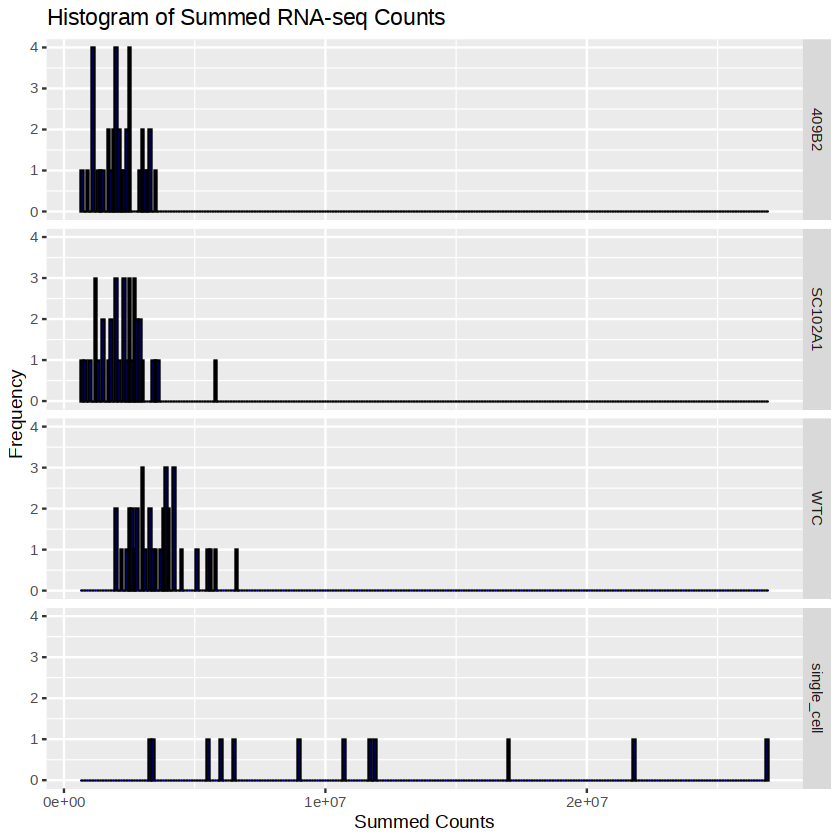

In [4]:

# Load your dataset
# Replace 'your_dataset.csv' with the path to your RNA-seq counts file
# and make sure the column containing counts is correctly specified.

# Assuming the counts are in a column named 'counts'
# Adjust 'counts' to the actual column name in your dataset
counts <- colSums(data)
# Create a dataframe from the counts for easier manipulation and plotting
counts_df <- data.frame(counts = counts)

meta['counts'] <- colSums(data)


# Plot a histogram of the counts
ggplot(meta, aes(x = counts)) +
  geom_histogram(binwidth = 100000, fill = 'blue', color = 'black') +
  ggtitle('Histogram of Summed RNA-seq Counts') +
  xlab('Summed Counts') +
  ylab('Frequency') +
  facet_grid(genotype ~ .)

# Display the lowest count values
lowest_counts <- counts_df %>% 
  arrange(counts) %>% 
  head(20)  # Displaying the 10 lowest counts; adjust as needed

print(lowest_counts)


In [5]:
# Define the minimum count threshold
min_count_threshold <- 600000  # Replace with your desired threshold

# Filter out samples (columns) with fewer than the minimum threshold counts
filtered_data <- data[, colSums(data) >= min_count_threshold]
filtered_meta <- meta[colSums(data) >= min_count_threshold,]


In [6]:
dim(filtered_meta)

[1] 120   4

In [7]:
dim(filtered_data)

[1] 60344   120

In [8]:
deseq2.colData <- data.frame(row.names=colnames(filtered_data))
#deseq2.colData$pattern <- 'pre'


deseq2.colData <- filtered_meta
deseq2.colData['sums'] <- colSums(filtered_data)

In [9]:
corner(deseq2.colData)

,genotype,repl,sample,counts,sums
,<chr>,<int>,<int>,<dbl>,<dbl>
Reproducibility_SC102A1_1_4,SC102A1,1,4,1039543,1039543
Reproducibility_SC102A1_1_9,SC102A1,1,9,2914538,2914538
Reproducibility_SC102A1_3_7,SC102A1,3,7,3432108,3432108
Reproducibility_SC102A1_2_12,SC102A1,2,12,694620,694620
Reproducibility_SC102A1_3_8,SC102A1,3,8,2490227,2490227


In [10]:
#colData$group <- factor(colData$group)

columns_to_factor <- c("sample","repl","genotype")
deseq2.colData <- deseq2.colData %>%
  mutate_at(vars(all_of(columns_to_factor)), factor)

#numeric_columns_to_scale <- c("t_int")
# Scale the specified numeric columns
#deseq2.colData <- deseq2.colData %>%
#  mutate_at(vars(all_of(numeric_columns_to_scale)), ~ scale(log(. + 1)))



In [11]:
deseq2.colData

,genotype,repl,sample,counts,sums
,<fct>,<fct>,<fct>,<dbl>,<dbl>
Reproducibility_SC102A1_1_4,SC102A1,1,4,1039543,1039543
Reproducibility_SC102A1_1_9,SC102A1,1,9,2914538,2914538
Reproducibility_SC102A1_3_7,SC102A1,3,7,3432108,3432108
Reproducibility_SC102A1_2_12,SC102A1,2,12,694620,694620
Reproducibility_SC102A1_3_8,SC102A1,3,8,2490227,2490227
Reproducibility_SC102A1_3_6,SC102A1,3,6,2306356,2306356
Reproducibility_SC102A1_1_1,SC102A1,1,1,2909196,2909196
Reproducibility_SC102A1_2_9,SC102A1,2,9,1206742,1206742
Reproducibility_SC102A1_2_6,SC102A1,2,6,1196901,1196901


In [12]:
total <- filtered_data
rownames(deseq2.colData) <- colnames(total)
dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ genotype + sample)

#dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ M_RA)

converting counts to integer mode



In [13]:
colnames(deseq2.colData)

[1] "genotype" "repl"     "sample"   "counts"   "sums"

In [14]:
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]

# Run Analysis
dds <- DESeq(dds)
res <- results(dds)
res <- res[order(rownames(res)), ]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [15]:
table(mcols(dds)$betaConv)


 TRUE 
37501 

In [16]:
#save median normalised counts
normalized_counts <- counts(dds, normalized=TRUE)
#write.table(normalized_counts, file="bulk/DESEQ2_norm_counts_stranded.tsv", sep="\t", quote=F, col.names=NA) 

In [17]:
vsd <- vst(dds, blind=FALSE)
#rld <- rlog(dds, blind=FALSE) 
vsd_orig <- vsd
write.table(assay(vsd_orig),"bulk/reproducibility_genotypes_deseq2_vsd_wSC.tsv",sep = "\t")


In [18]:
mat <- assay(vsd)
mm <- model.matrix(~ sample, colData(vsd))
mat <- limma::removeBatchEffect(mat, batch=vsd$genotype, design=mm)
assay(vsd) <- mat

write.table(assay(vsd),"bulk/reproducibility_genotypes_deseq2_vsd_corr_wSC.tsv",sep = "\t")


In [31]:
library(RColorBrewer)             # Load the library

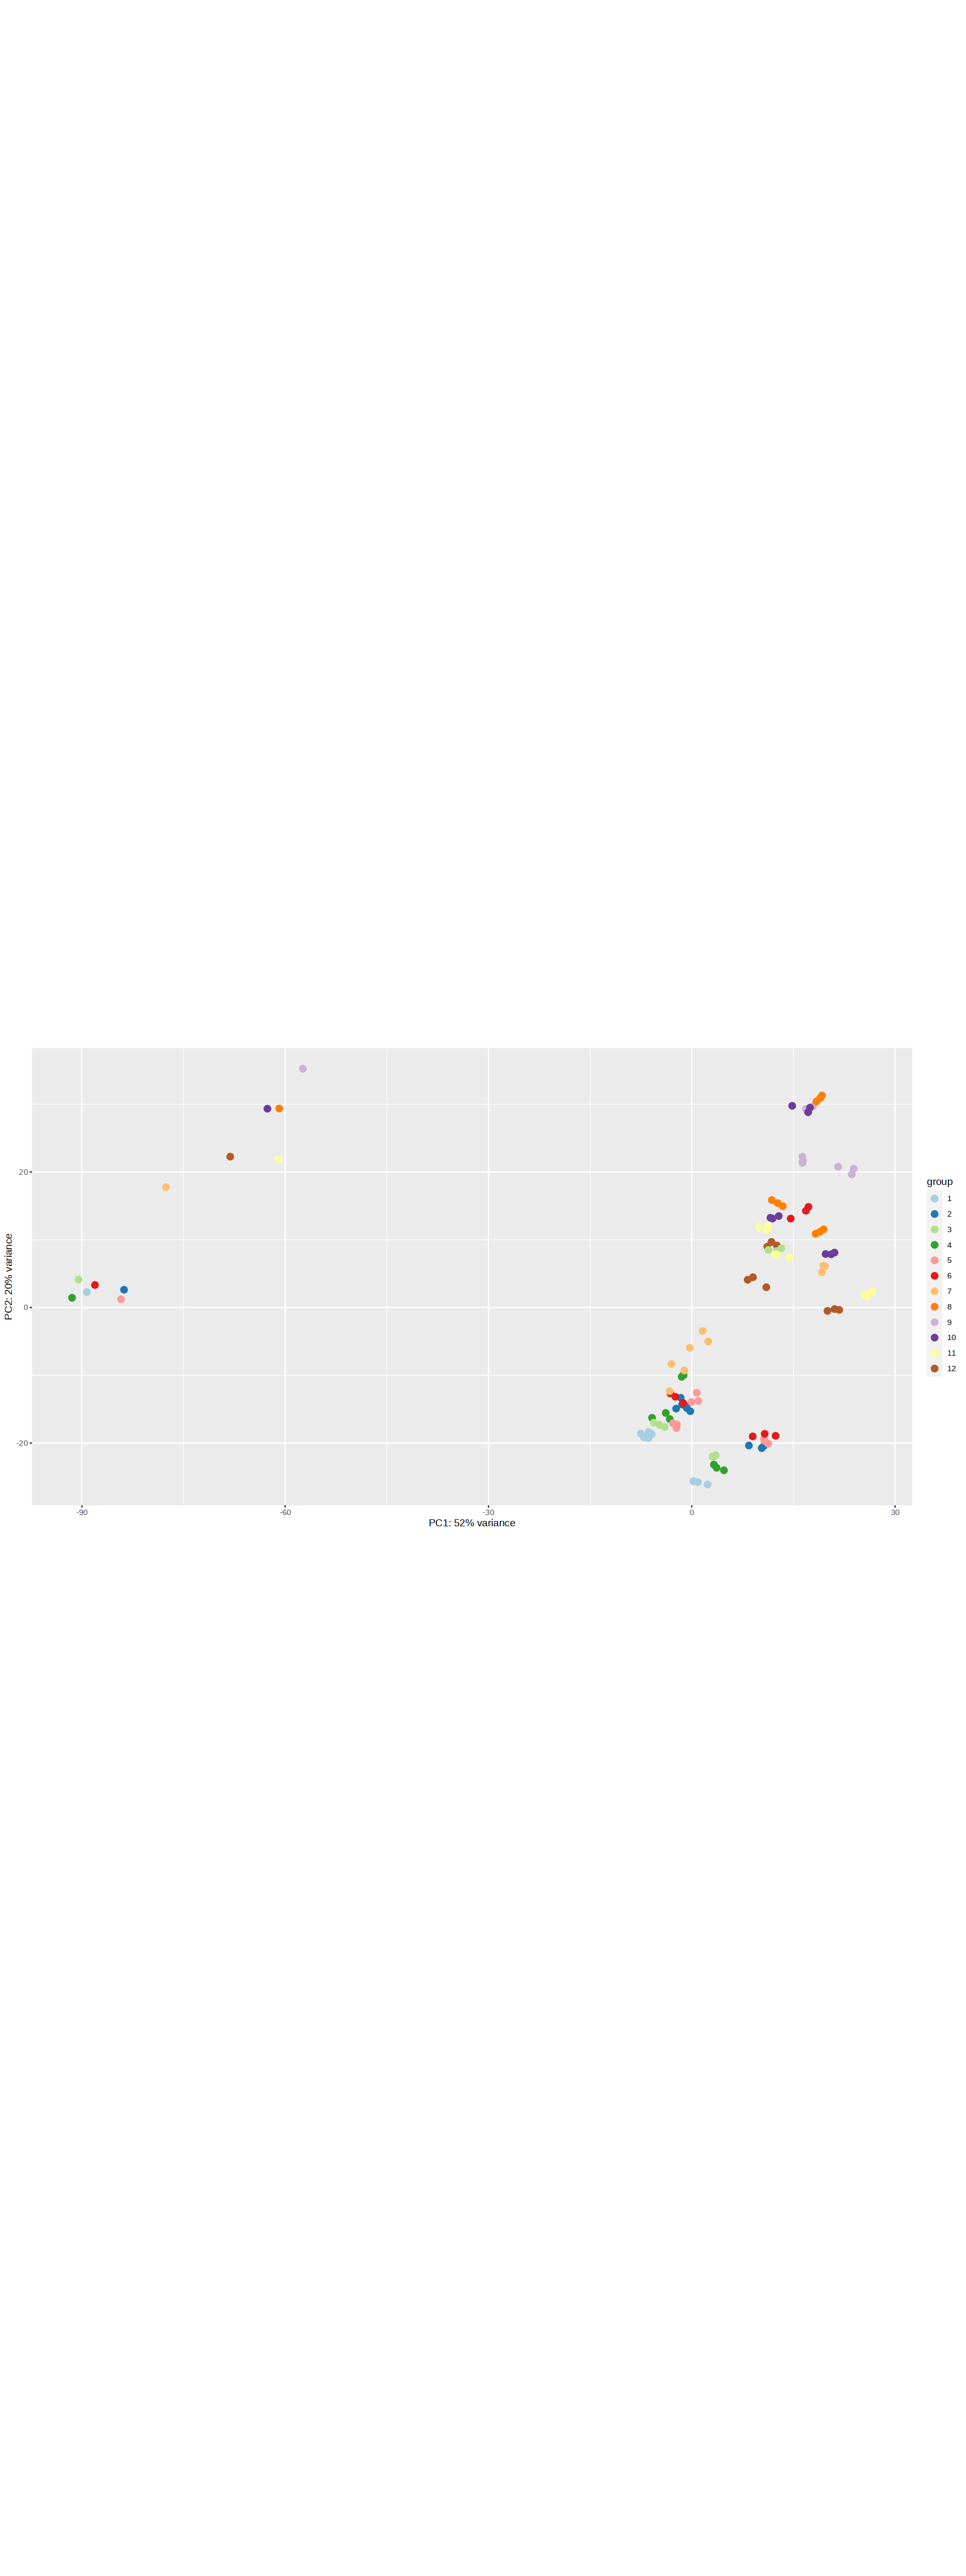

In [44]:
pca_plot <- plotPCA(vsd_orig,intgroup=c('sample'))

pca_plot <- pca_plot + 
  scale_color_brewer(palette = "Paired")  # "Paired" is a good choice for distinct colors
# Display the plot
print(pca_plot)
ggsave("figures/reproducibility_PCA_orig_sample.pdf", plot = pca_plot, width = 6, height = 6)

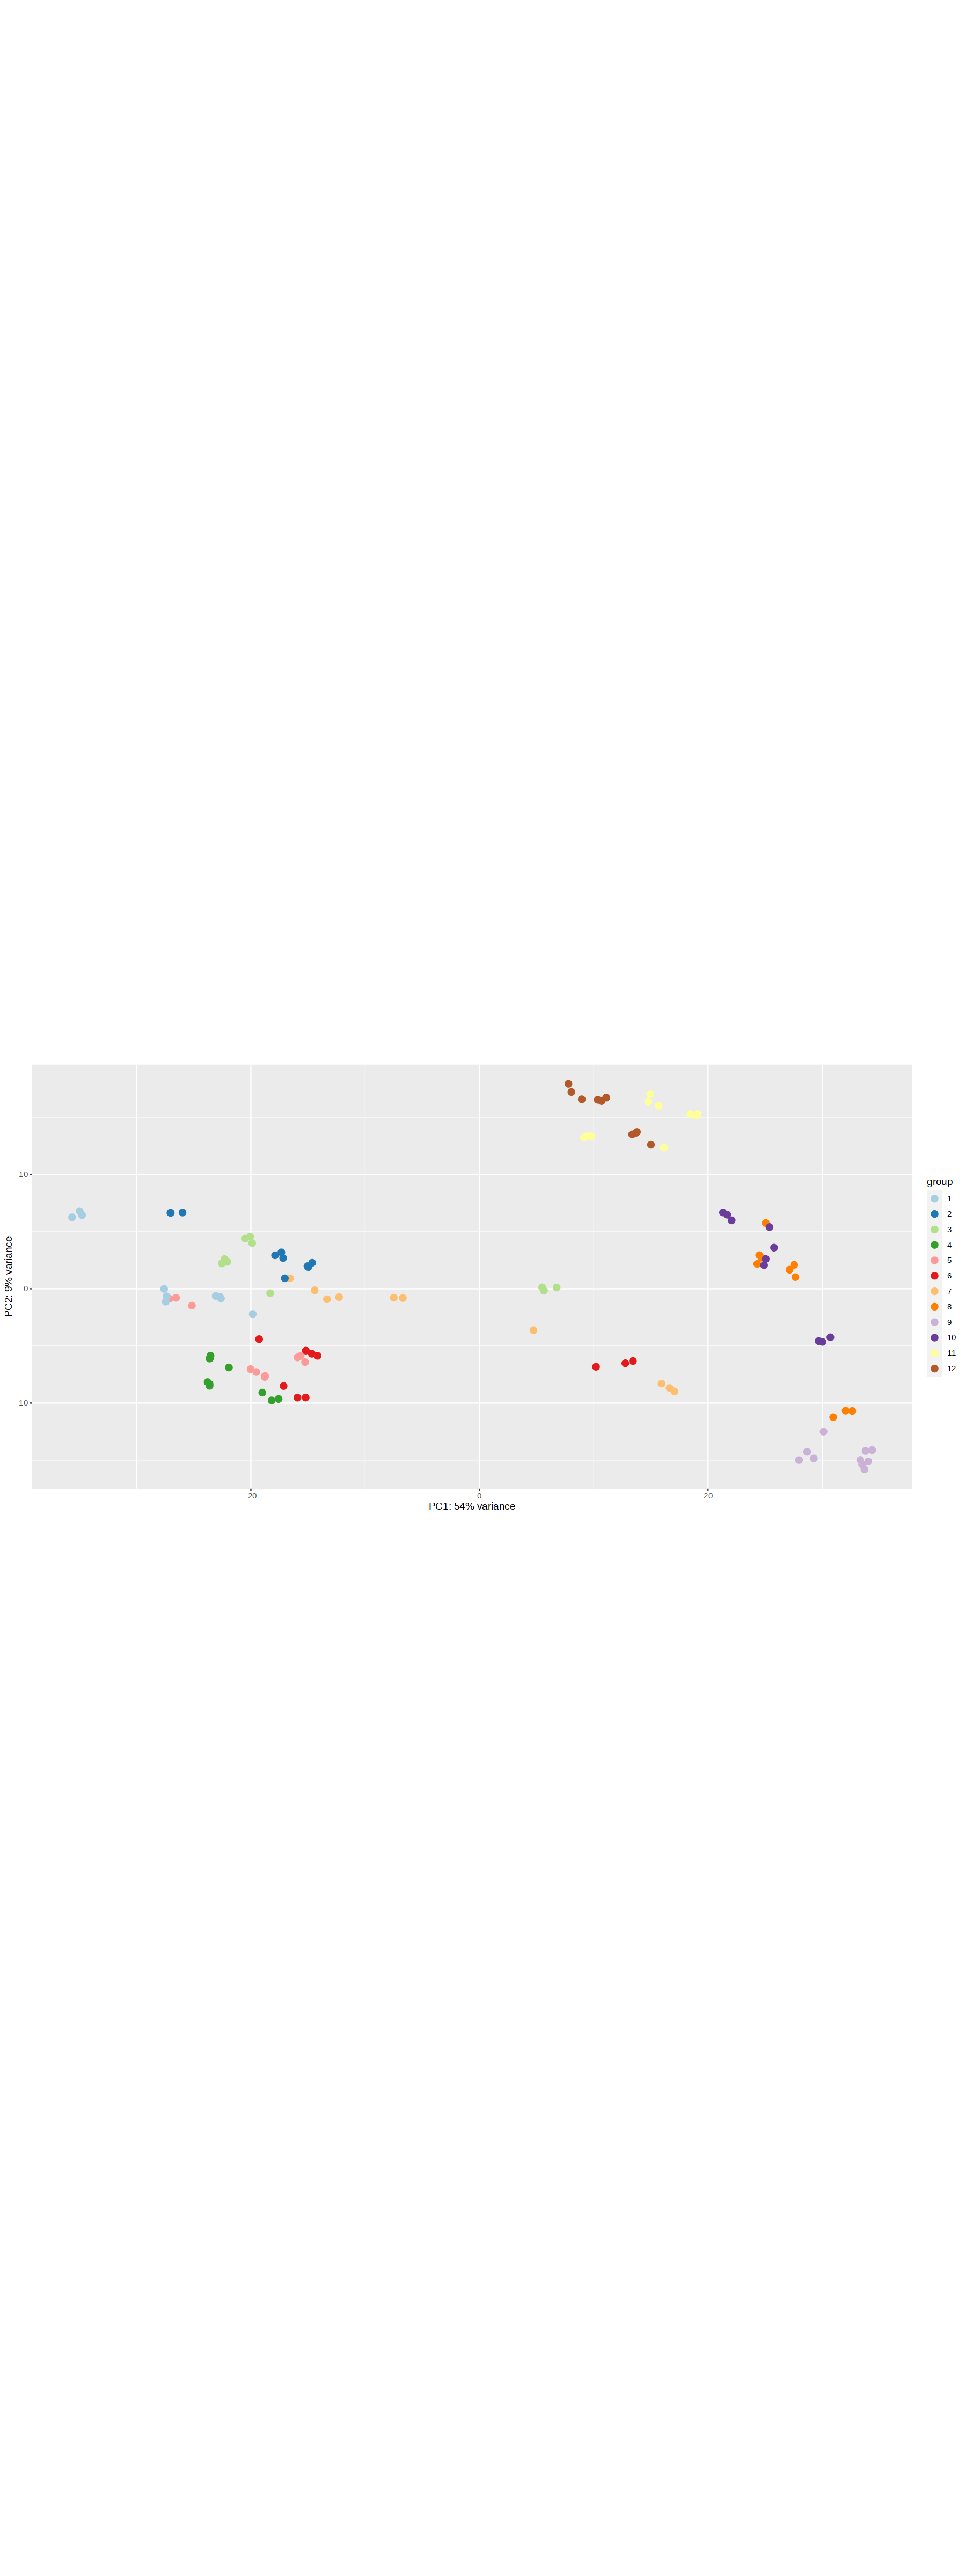

In [45]:
pca_plot <- plotPCA(vsd,intgroup=c('sample'))

pca_plot <- pca_plot + 
  scale_color_brewer(palette = "Paired")
# Display the plot
print(pca_plot)
ggsave("figures/reproducibility_PCA_bc_sample.pdf", plot = pca_plot, width = 6, height = 6)

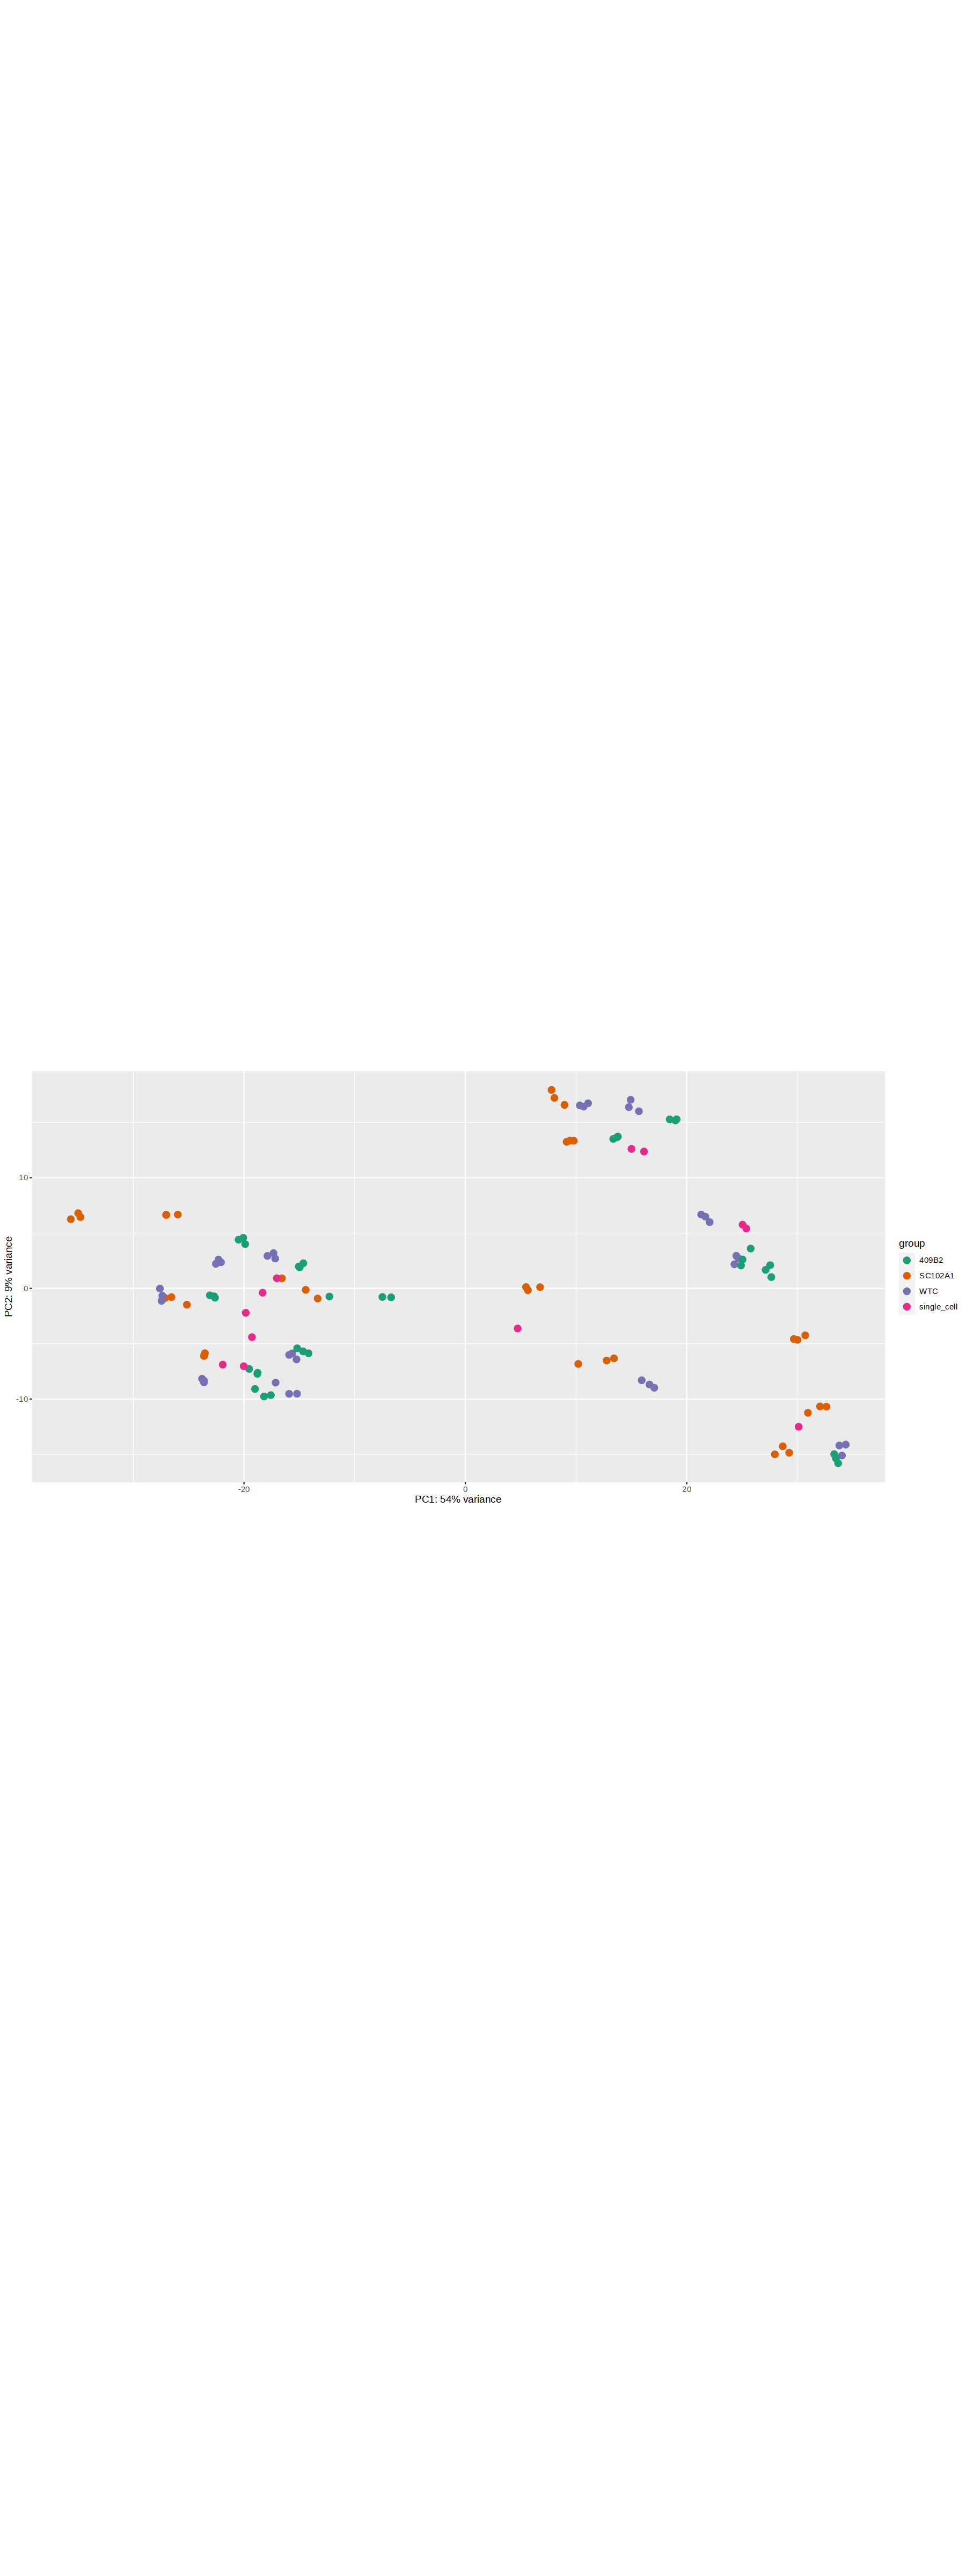

In [46]:
pca_plot <- plotPCA(vsd,intgroup=c('genotype'))

pca_plot <- pca_plot + 
  scale_color_brewer(palette = "Dark2")
# Display the plot
print(pca_plot)
ggsave("figures/reproducibility_PCA_bc_genotype.pdf", plot = pca_plot, width = 6, height = 6)

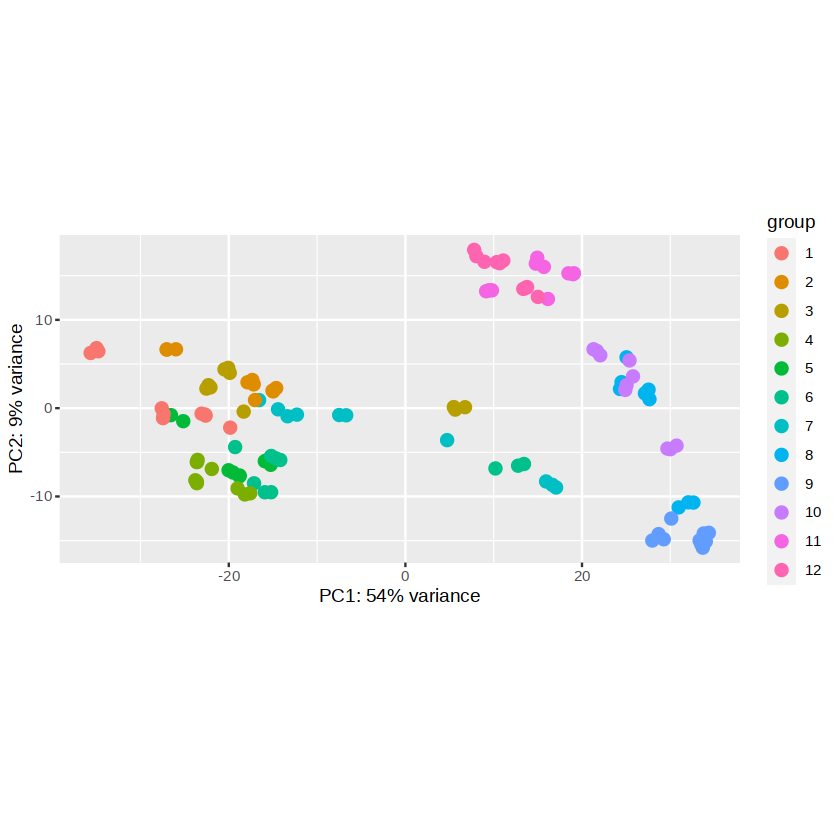

In [20]:
plotPCA(vsd,intgroup=c('sample'))

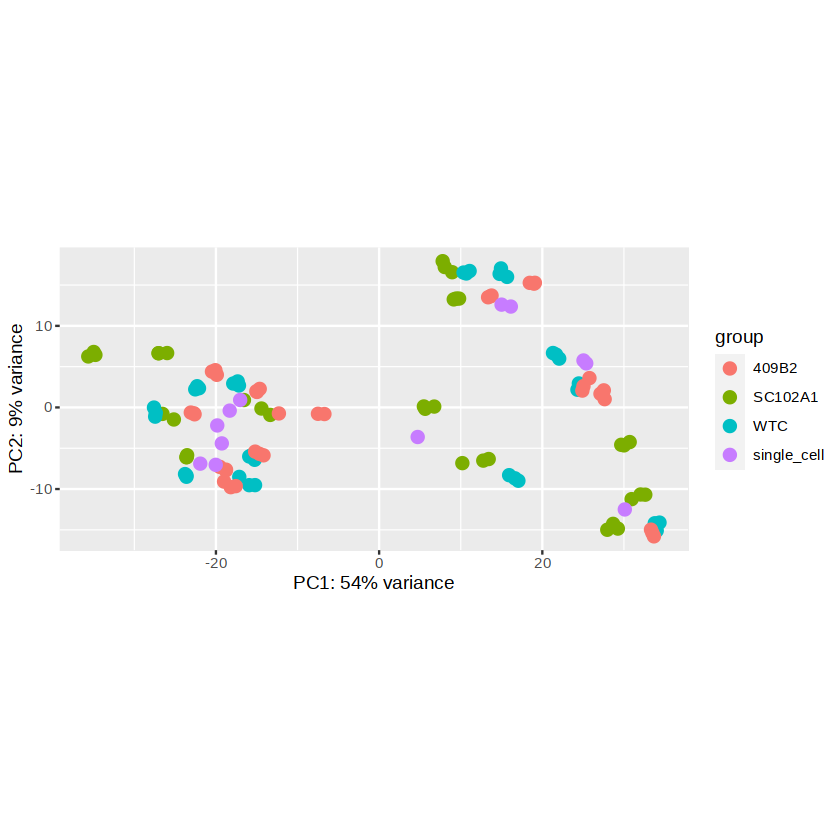

In [21]:
plotPCA(vsd,intgroup=c('genotype'))

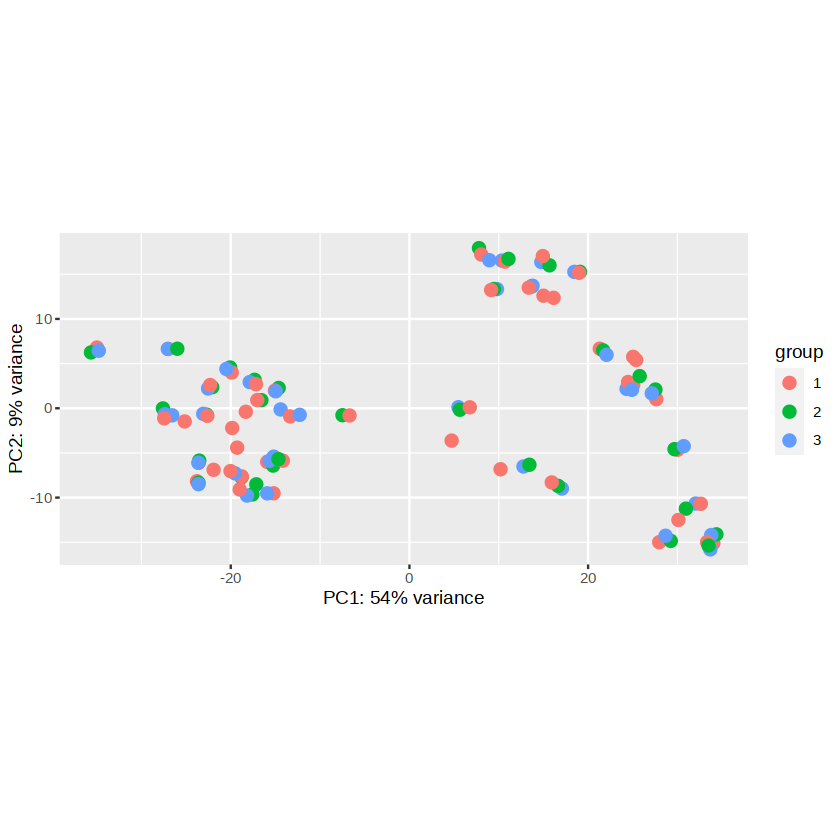

In [22]:
plotPCA(vsd,intgroup=c('repl'))

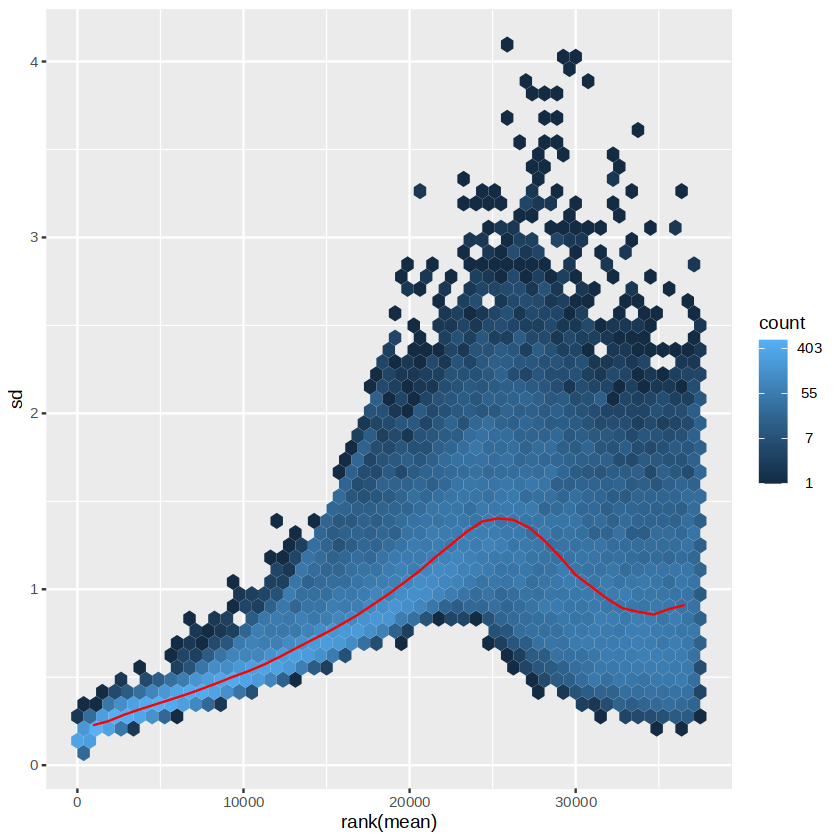

In [23]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library("vsn")
meanSdPlot(assay(ntd)) 

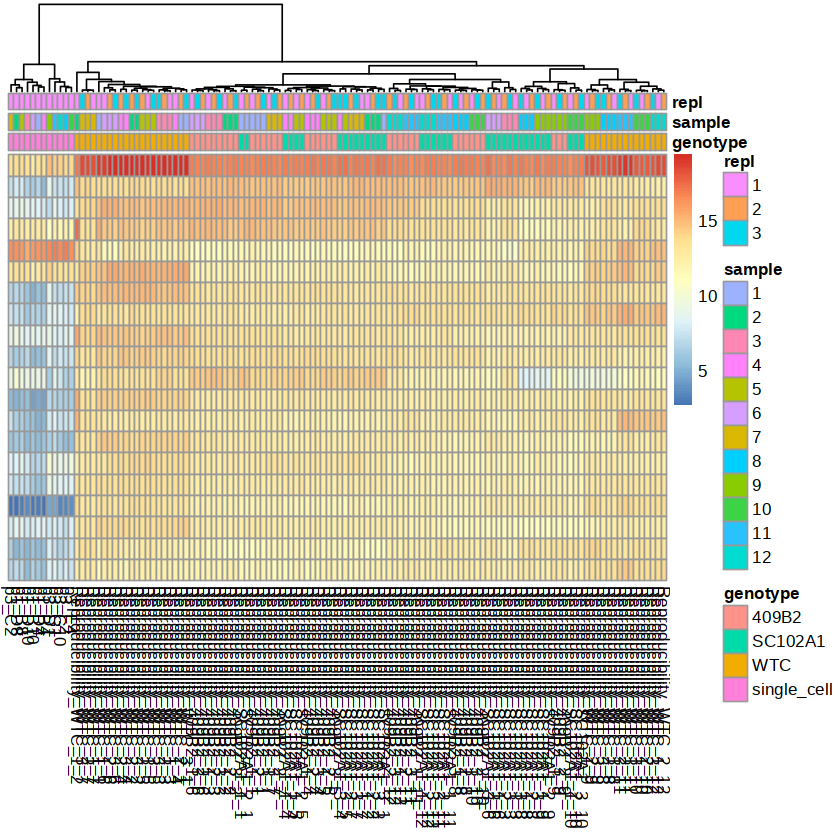

In [24]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("genotype","sample","repl")])
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)

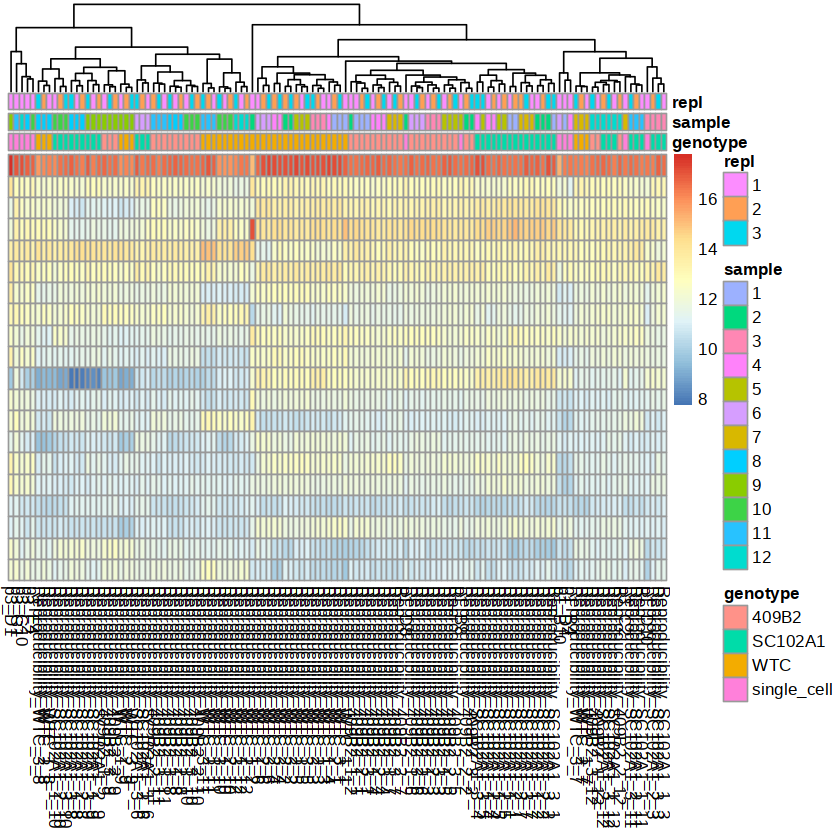

In [25]:
library("pheatmap")
select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("genotype","sample","repl")])
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)

In [26]:
sampleDists <- dist(t(assay(vsd)))
tst <- as.data.frame(as.matrix(sampleDists))
write.table(tst,"bulk/reproducibility_genotypes_deseq2_limma_corr_pca_distances_wSC.tsv",sep = "\t")

In [27]:
sampleDists <- dist(t(assay(vsd)))

In [28]:
library(repr)



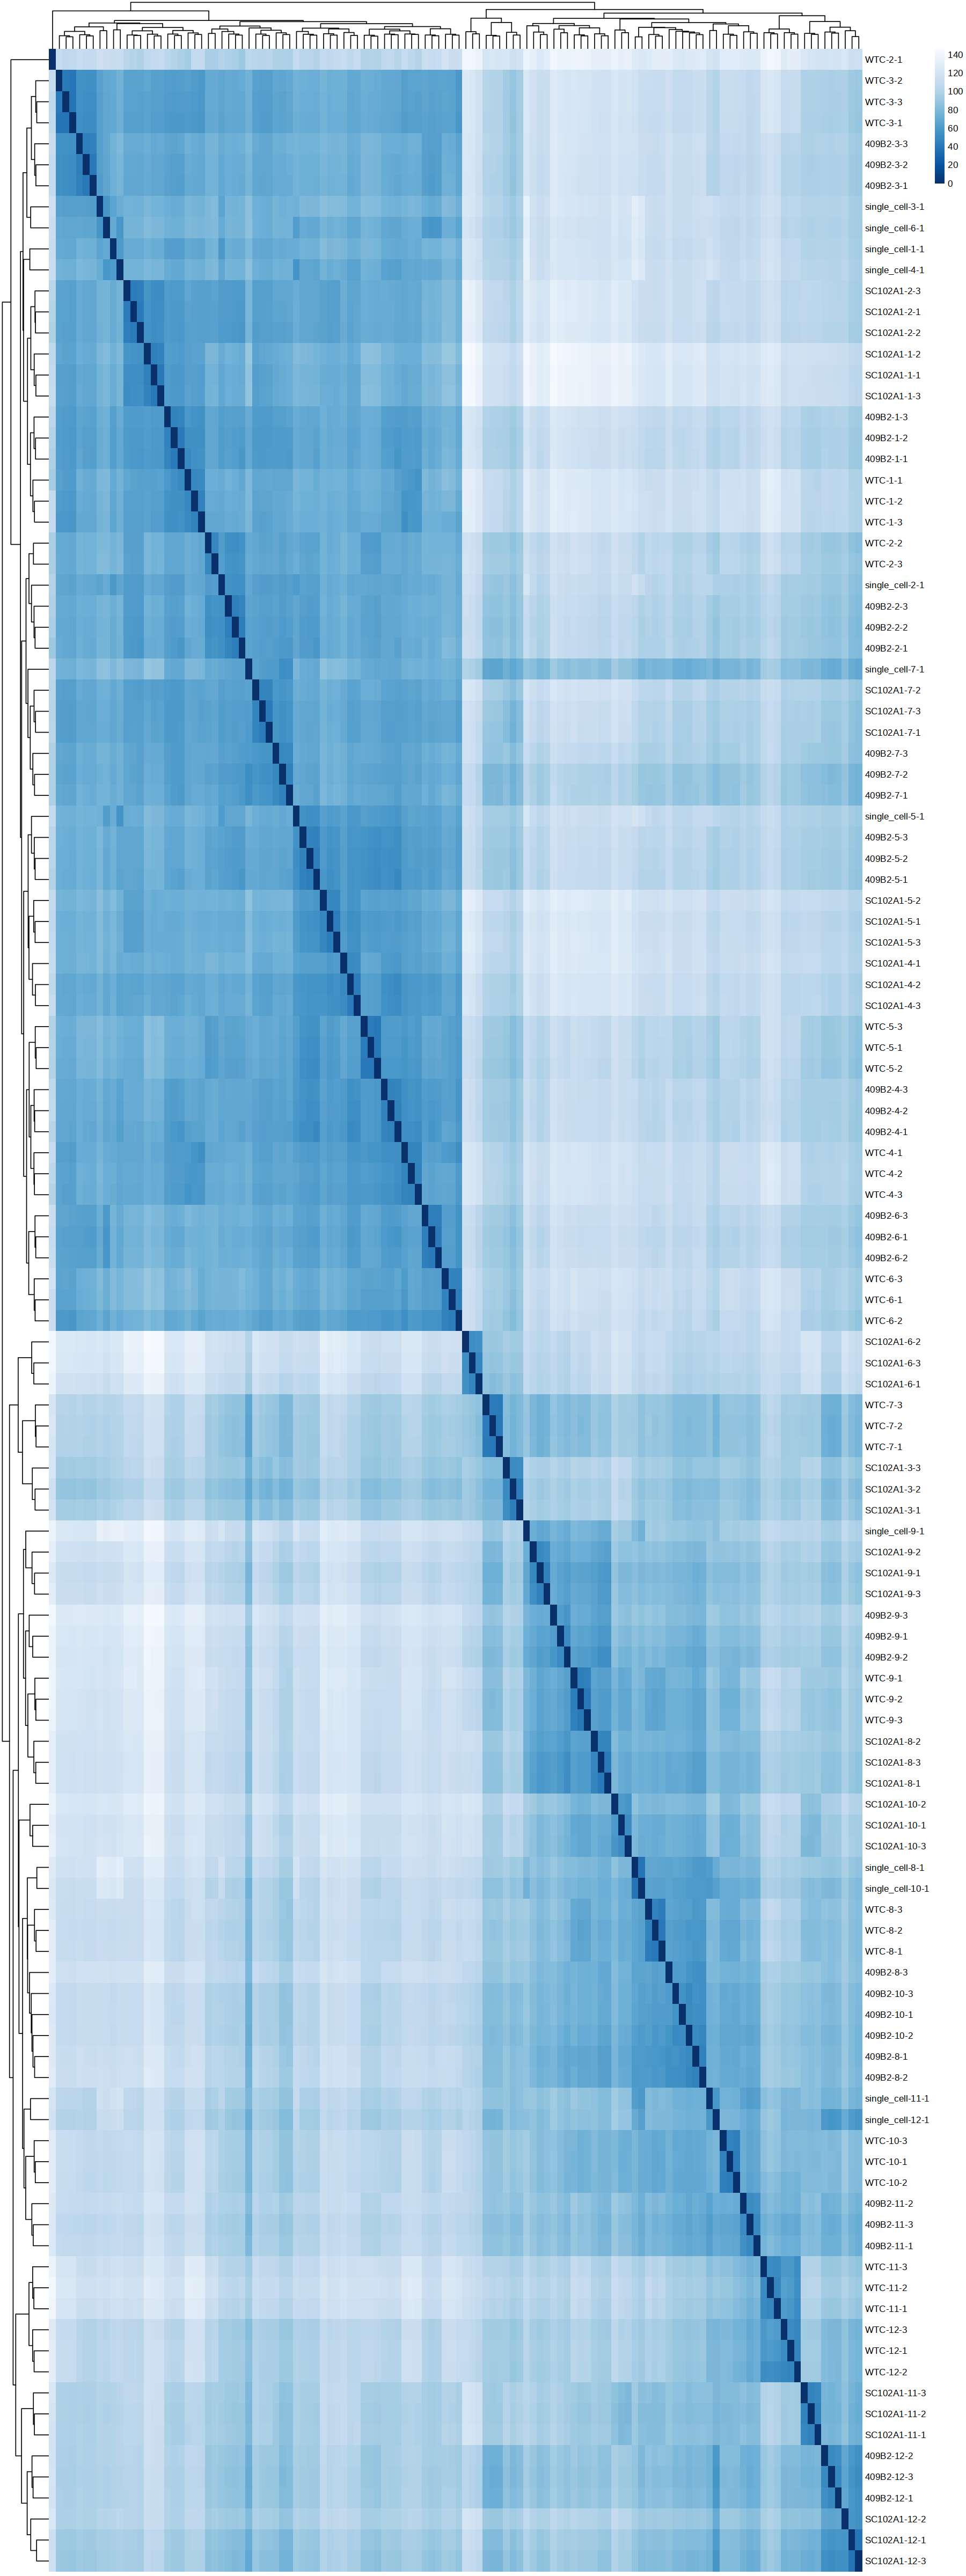

In [29]:
library("RColorBrewer")
sampleDistMatrix <- as.matrix(sampleDists)

rownames(sampleDistMatrix) <- paste(vsd$genotype,vsd$sample,vsd$repl, sep="-")
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)

# Set plot size
options(repr.plot.width=15, repr.plot.height=40)

pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         col=colors)

In [45]:
colnames(mm)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'colnames': object 'mm' not found


In [46]:
dds

class: DESeqDataSet 
dim: 29162 72 
metadata(1): version
assays(4): counts mu H cooks
rownames(29162): 5S_rRNA 7SK ... ZZEF1 ZZZ3
rowData names(66): baseMean baseVar ... deviance maxCooks
colnames(72): Stability_d21_sample_9 Stability_d21_sample_4 ...
  Stability_d28_sample_6 Stability_d28_sample_5
colData names(5): t sample t_int sums sizeFactor

In [48]:
cname <- "t_int"
res_M_RA <- results(dds, name = cname)
resApe = lfcShrink(dds,res=res_M_RA,coef = cname,type="apeglm", lfcThreshold=1)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

computing FSOS 'false sign or small' s-values (T=1)



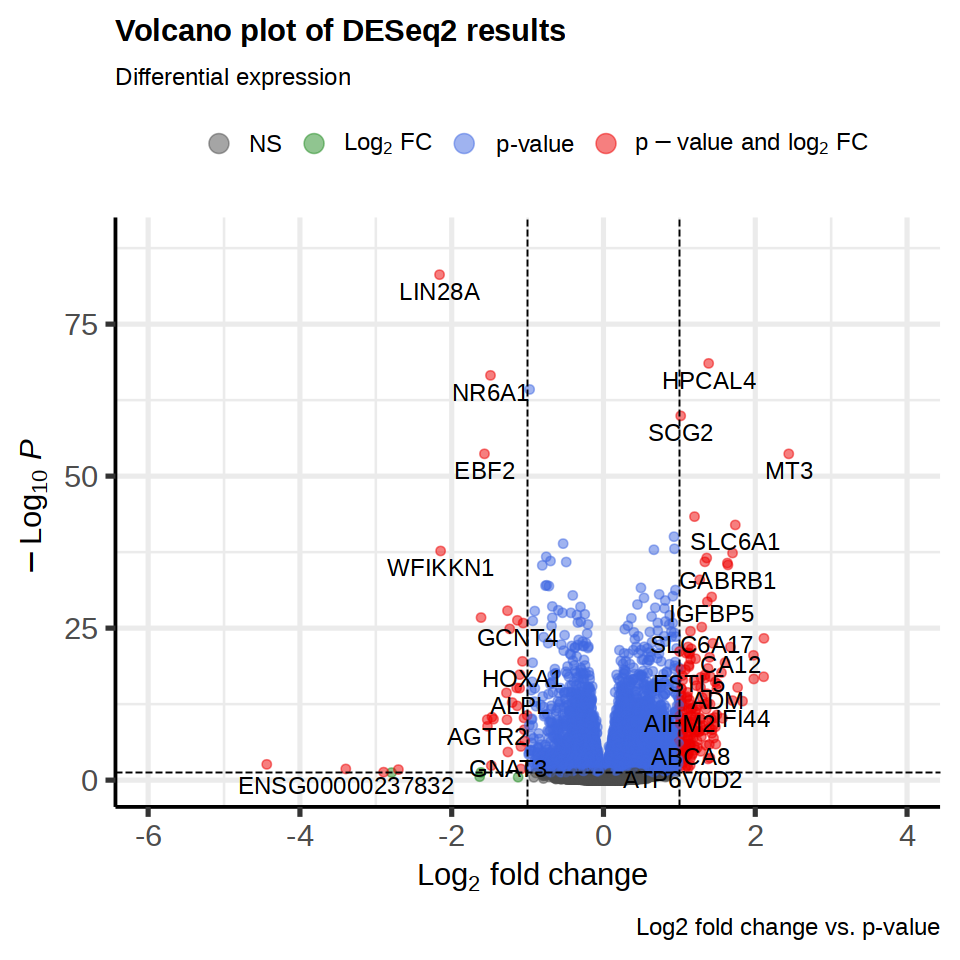

In [49]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



In [52]:
res_df <- as.data.frame(res)

In [54]:
write.table(res_df,"stability_plots/deseq2_time.tsv",sep="\t")

In [55]:
results(dds)

log2 fold change (MLE): sample 12 vs 1 
Wald test p-value: sample 12 vs 1 
DataFrame with 29162 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat    pvalue      padj
          <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
5S_rRNA    0.265838      -1.406363  4.842766 -0.290405 0.7715065        NA
7SK        0.308035       1.222261  2.452998  0.498272 0.6182921        NA
A1BG       8.771649      -1.213015  0.471891 -2.570540 0.0101540 0.0379616
A1BG-AS1  10.408437      -0.655534  0.376213 -1.742455 0.0814289 0.1861251
A1CF       0.250052       0.256325  2.993195  0.085636 0.9317558        NA
...             ...            ...       ...       ...       ...       ...
ZYG11A     0.716791       0.960006  1.451382  0.661442 0.5083288        NA
ZYG11B   157.771008      -0.480869  0.175060 -2.746876 0.0060166 0.0250397
ZYX       47.941601       0.294513  0.290117  1.015154 0.3100326 0.4854060
ZZEF1     56.580479       0.161184  0.247206  0.652021 0.514

In [56]:
res <- results(dds, contrast = c('sample', '12', '2'), alpha = 0.05)


In [57]:
res

log2 fold change (MLE): sample 12 vs 2 
Wald test p-value: sample 12 vs 2 
DataFrame with 29162 rows and 6 columns
           baseMean log2FoldChange     lfcSE       stat    pvalue      padj
          <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
5S_rRNA    0.265838      -0.073714  4.857542 -0.0151752 0.9878924        NA
7SK        0.308035       0.855730  2.453048  0.3488435 0.7272068        NA
A1BG       8.771649      -1.079453  0.472030 -2.2868322 0.0222056  0.108322
A1BG-AS1  10.408437      -0.625837  0.373688 -1.6747573 0.0939819  0.278545
A1CF       0.250052      -0.553681  2.989380 -0.1852162 0.8530595        NA
...             ...            ...       ...        ...       ...       ...
ZYG11A     0.716791     -1.2554495  1.300670  -0.965233  0.334428        NA
ZYG11B   157.771008     -0.1485424  0.176105  -0.843488  0.398956  0.652660
ZYX       47.941601     -0.0457835  0.283709  -0.161375  0.871798  0.946148
ZZEF1     56.580479      0.3024945  0.247225   1.

In [64]:
sampleInfo <- deseq2.colData
sampleNames <- levels(sampleInfo$sample)
markerGenesList <- list()

for (sample in sampleNames) {
    print(sample)
    otherSamples <- sampleNames[sampleNames != sample]
    sampleVsOthers <- relevel(factor(ifelse(sampleInfo$sample == sample, sample, "others")), ref = "others")
    deseq2.colData$condition <- sampleVsOthers

    
    dds <- DESeqDataSetFromMatrix(countData = total, colData = deseq2.colData,design = ~ t_int + condition)
    keep <- rowSums(counts(dds)) >= 10
    dds <- dds[keep,]

    dds <- DESeq(dds)
    res <- results(dds, contrast = c("condition", sample, "others"))
    markerGenesList[[sample]] <- res
}


[1] "1"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 142 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "2"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 144 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "3"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 150 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "4"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 153 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "5"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 155 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "6"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 142 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "7"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 157 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "8"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 185 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "9"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 145 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "10"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 164 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "11"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 165 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "12"


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 165 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [71]:
res_M_RA

log2 fold change (MLE): condition 1 vs others 
Wald test p-value: condition 1 vs others 
DataFrame with 29162 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat    pvalue      padj
          <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
5S_rRNA    0.265838       1.416548  2.182451  0.649063  0.516298        NA
7SK        0.308035      -0.610354  1.384163 -0.440955  0.659245        NA
A1BG       8.771649       0.525514  0.355174  1.479598  0.138980  0.345499
A1BG-AS1  10.408437       0.291006  0.301977  0.963669  0.335212  0.567821
A1CF       0.250052      -0.517475  1.544807 -0.334977  0.737642        NA
...             ...            ...       ...       ...       ...       ...
ZYG11A     0.716791     -1.2062149  1.046554 -1.152559 0.2490914        NA
ZYG11B   157.771008      0.2083399  0.148843  1.399725 0.1615957 0.3767991
ZYX       47.941601     -0.5551411  0.302653 -1.834247 0.0666173 0.2257292
ZZEF1     56.580479     -0.0474588  0.187138 -

In [73]:
res_M_RA

log2 fold change (MLE): condition 1 vs others 
Wald test p-value: condition 1 vs others 
DataFrame with 29162 rows and 6 columns
           baseMean log2FoldChange     lfcSE      stat    pvalue      padj
          <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
5S_rRNA    0.265838       1.416548  2.182451  0.649063  0.516298        NA
7SK        0.308035      -0.610354  1.384163 -0.440955  0.659245        NA
A1BG       8.771649       0.525514  0.355174  1.479598  0.138980  0.345499
A1BG-AS1  10.408437       0.291006  0.301977  0.963669  0.335212  0.567821
A1CF       0.250052      -0.517475  1.544807 -0.334977  0.737642        NA
...             ...            ...       ...       ...       ...       ...
ZYG11A     0.716791     -1.2062149  1.046554 -1.152559 0.2490914        NA
ZYG11B   157.771008      0.2083399  0.148843  1.399725 0.1615957 0.3767991
ZYX       47.941601     -0.5551411  0.302653 -1.834247 0.0666173 0.2257292
ZZEF1     56.580479     -0.0474588  0.187138 -

In [75]:
resultsNames(dds)

[1] "Intercept"              "t_int"                  "condition_12_vs_others"

In [89]:
options(repr.plot.width=8, repr.plot.height=8)

for (sample in sampleNames) {
    res <- markerGenesList[[sample]]
    # Generate volcano plot
    
    png(filename = paste0("stability_plots/", sample, "_deseq2.png"), width = 800, height = 800)
    temp_plot <- EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')
    ggsave(temp_plot, file=paste0("stability_plots/", sample, "_deseq2.png"), width = 14, height = 30, units = "cm")

    dev.off()

    write.table(as.data.frame(res),paste0("stability_plots/",sample,"_deseq2.tsv"),sep="\t")

    }



In [85]:
res

log2 fold change (MLE): condition 12 vs others 
Wald test p-value: condition 12 vs others 
DataFrame with 29162 rows and 6 columns
           baseMean log2FoldChange     lfcSE       stat    pvalue      padj
          <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
5S_rRNA    0.265838      -0.102561  2.225098 -0.0460928 0.9632363        NA
7SK        0.308035       0.690557  1.342042  0.5145565 0.6068630        NA
A1BG       8.771649      -0.777405  0.396917 -1.9586115 0.0501583  0.298841
A1BG-AS1  10.408437      -0.432244  0.318962 -1.3551577 0.1753673  0.501875
A1CF       0.250052      -0.239523  1.543721 -0.1551595 0.8766956        NA
...             ...            ...       ...        ...       ...       ...
ZYG11A     0.716791     -0.1796719  0.972246  -0.184801 0.8533852        NA
ZYG11B   157.771008     -0.3086735  0.148186  -2.083021 0.0372493  0.262366
ZYX       47.941601     -0.2211158  0.300578  -0.735635 0.4619527  0.750174
ZZEF1     56.580479      0.126156

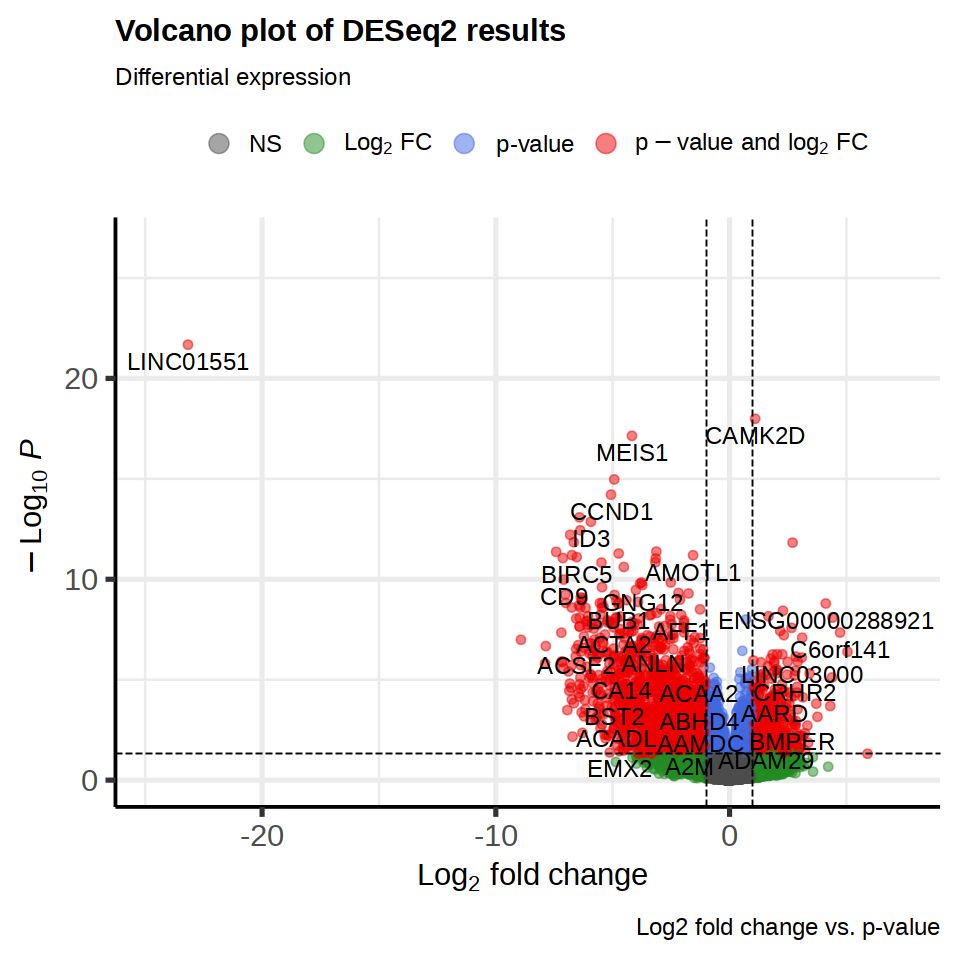

In [76]:
res <- markerGenesList$'1'
#resApe = lfcShrink(dds,res=res_M_RA,coef = 'condition_1_vs_others', type="apeglm", lfcThreshold=1)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



In [73]:
res_M_RA <- results(dds, name = "M_RA")
resAshT <- lfcShrink(dds,res=res_M_RA, coef=2, type="ashr", lfcThreshold=1)

In [102]:
cname <- "M_CHIR"
res_M_RA <- results(dds, name = cname)
resApe = lfcShrink(dds,res=res_M_RA,coef = cname,type="apeglm", lfcThreshold=1)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

computing FSOS 'false sign or small' s-values (T=1)



In [106]:
resApe

log2 fold change (MAP): M CHIR 
 
DataFrame with 26046 rows and 4 columns
          baseMean log2FoldChange      lfcSE    svalue
         <numeric>      <numeric>  <numeric> <numeric>
A1BG     11.078487   -0.000584181 0.00933743  0.938416
A1BG-AS1  3.003253   -0.000272153 0.00932950  0.939425
A1CF      0.314303    0.000120784 0.00934962  0.940402
A2M       4.446005    0.000619178 0.00934987  0.941348
A2M-AS1   3.967147    0.000363301 0.00933816  0.942265
...            ...            ...        ...       ...
ZYG11A     8.57726   -0.000542641 0.00935357  0.999858
ZYG11B   115.37802    0.000633110 0.00894191  0.999858
ZYX      175.03781   -0.002916402 0.00998571  0.999858
ZZEF1     36.65814   -0.002135274 0.00947873  0.999858
ZZZ3     302.21323    0.019338482 0.02287828  0.999858

In [105]:
res_M_RA

log2 fold change (MLE): M CHIR 
Wald test p-value: M CHIR 
DataFrame with 26046 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat     pvalue      padj
         <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
A1BG     11.078487     -0.0683902 0.0988031 -0.692187   0.488820  0.999957
A1BG-AS1  3.003253     -0.0736893 0.1245498 -0.591645   0.554088  0.999957
A1CF      0.314303      0.1309667 0.4568507  0.286673   0.774363  0.999957
A2M       4.446005      0.0165454 0.1159063  0.142748   0.886489  0.999957
A2M-AS1   3.967147      0.0780098 0.1346004  0.579566   0.562208  0.999957
...            ...            ...       ...       ...        ...       ...
ZYG11A     8.57726    -0.13051017 0.1459803 -0.894026 0.37130807  0.999957
ZYG11B   115.37802     0.00616459 0.0294312  0.209458 0.83409083  0.999957
ZYX      175.03781    -0.28521676 0.0926346 -3.078945 0.00207735  0.490978
ZZEF1     36.65814    -0.05092152 0.0434352 -1.172357 0.24105376  0.999957
Z

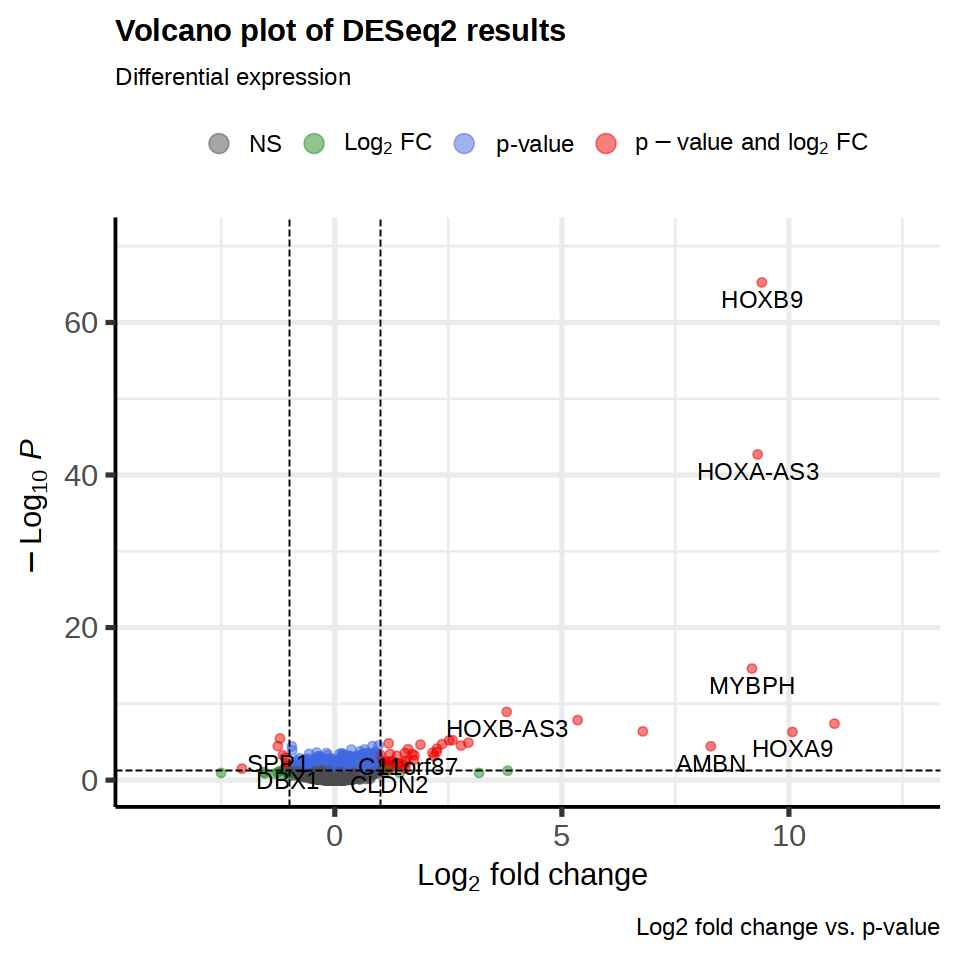

In [103]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



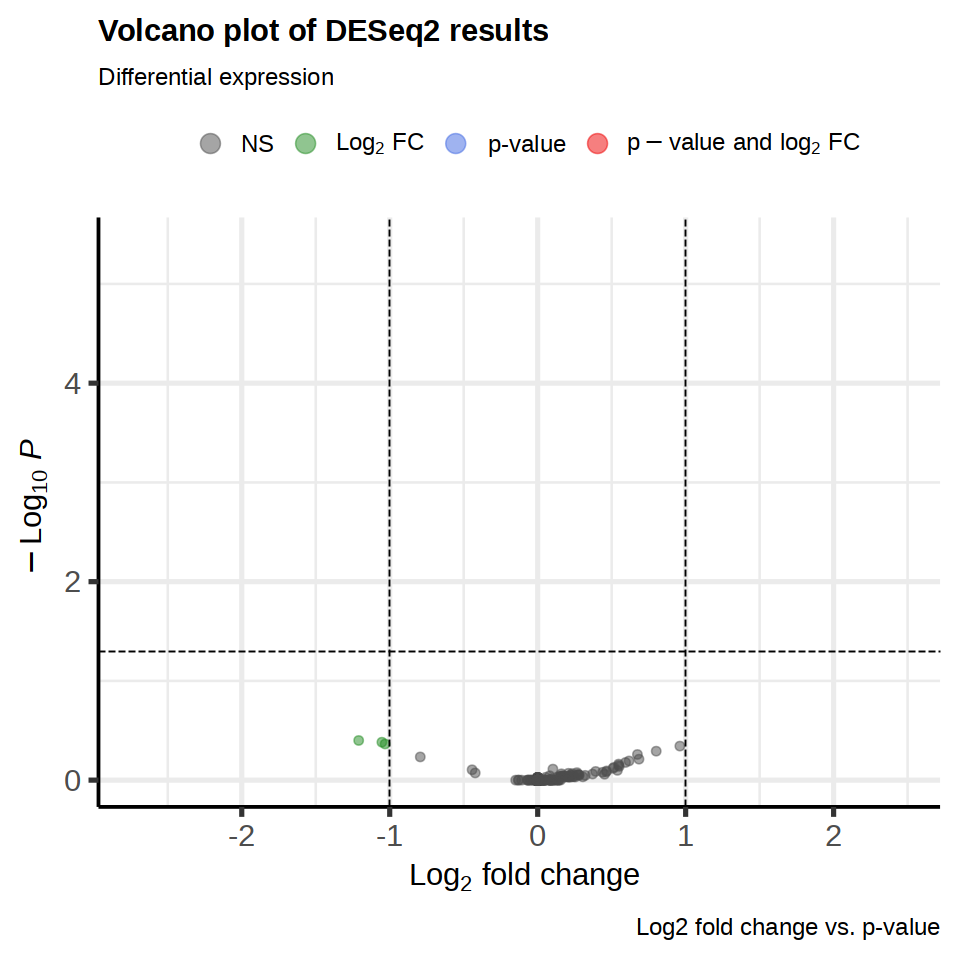

In [104]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



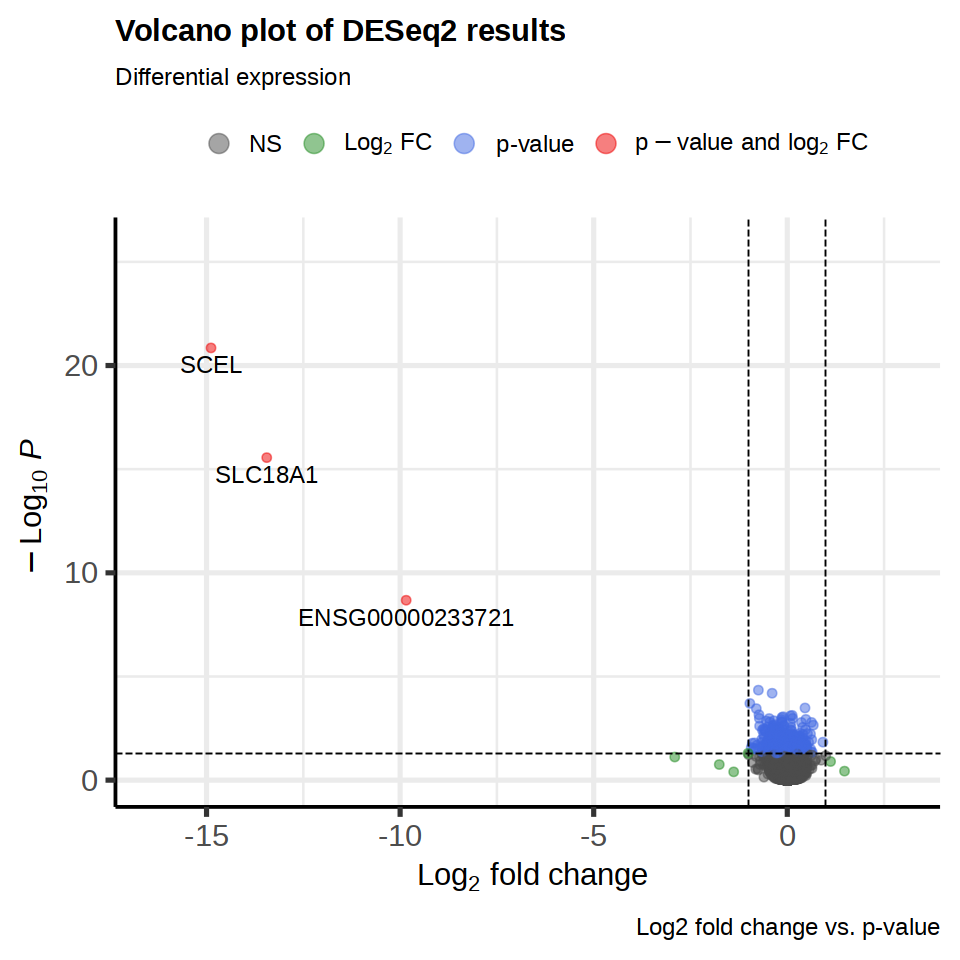

In [98]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



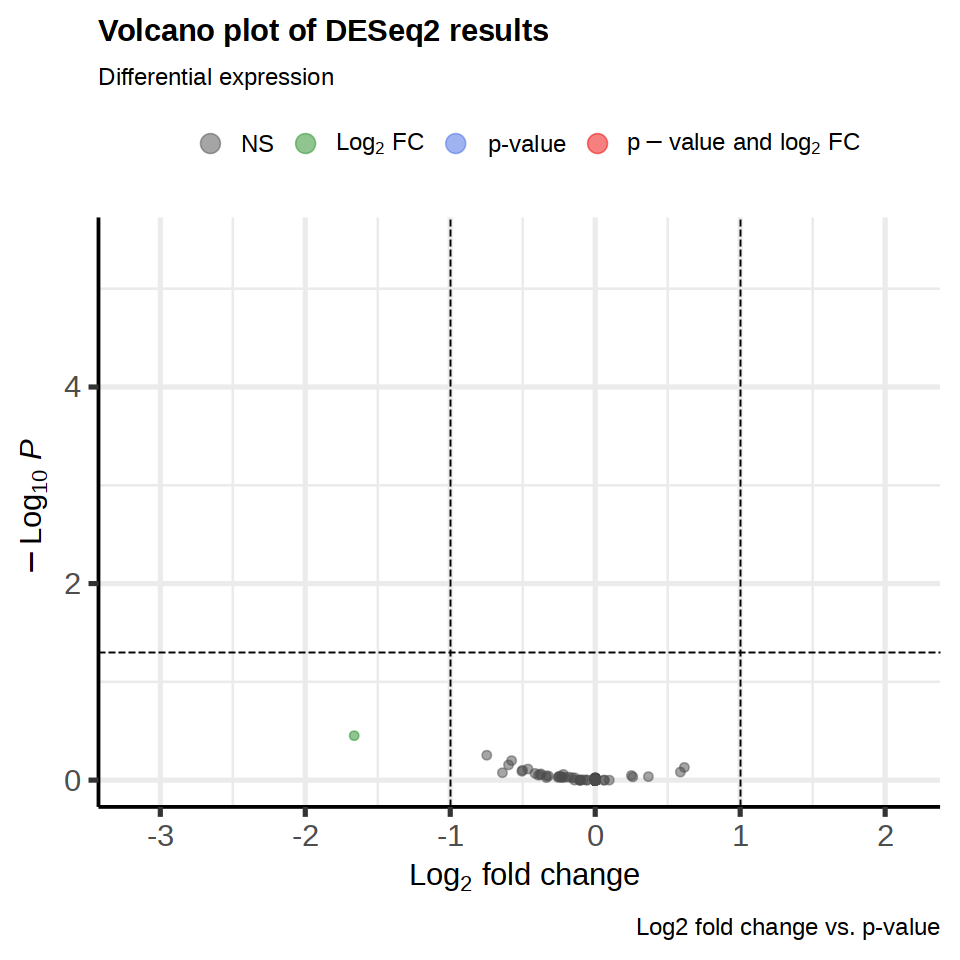

In [96]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



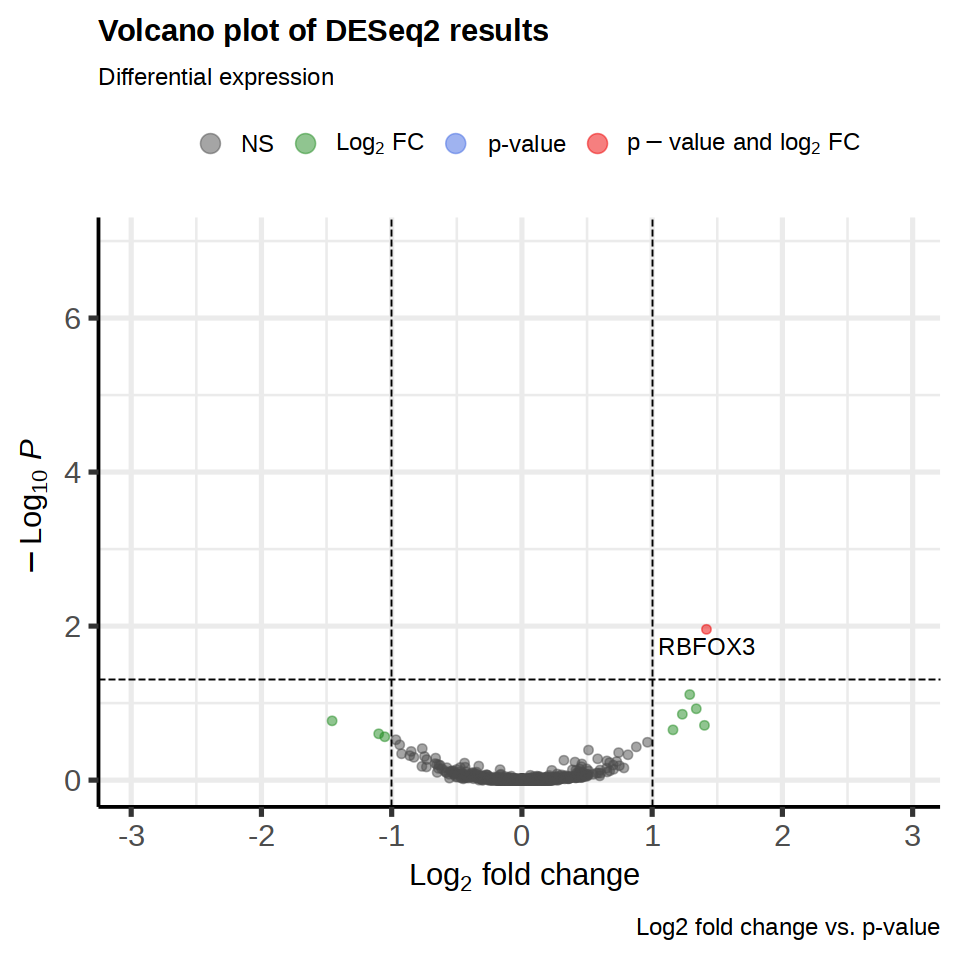

In [93]:
# Get results
res <- resApe

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'svalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')



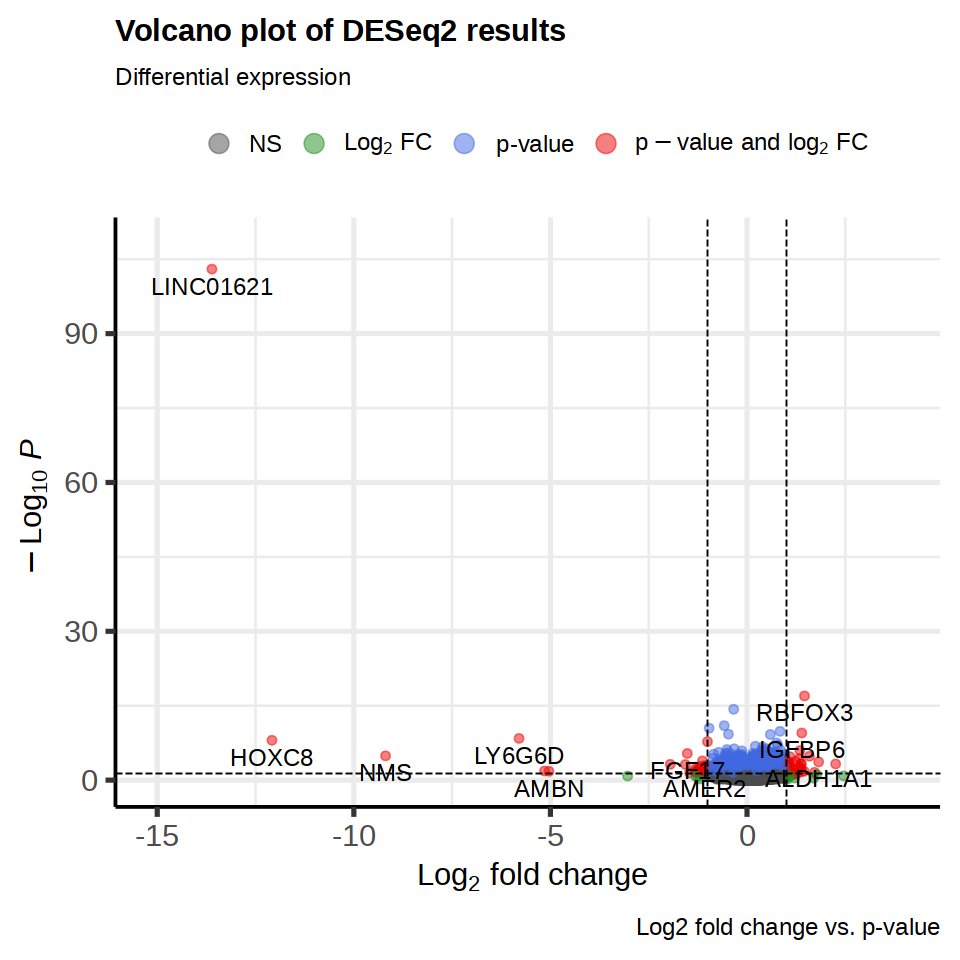

In [82]:
# Get results
res <- res_M_RA

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


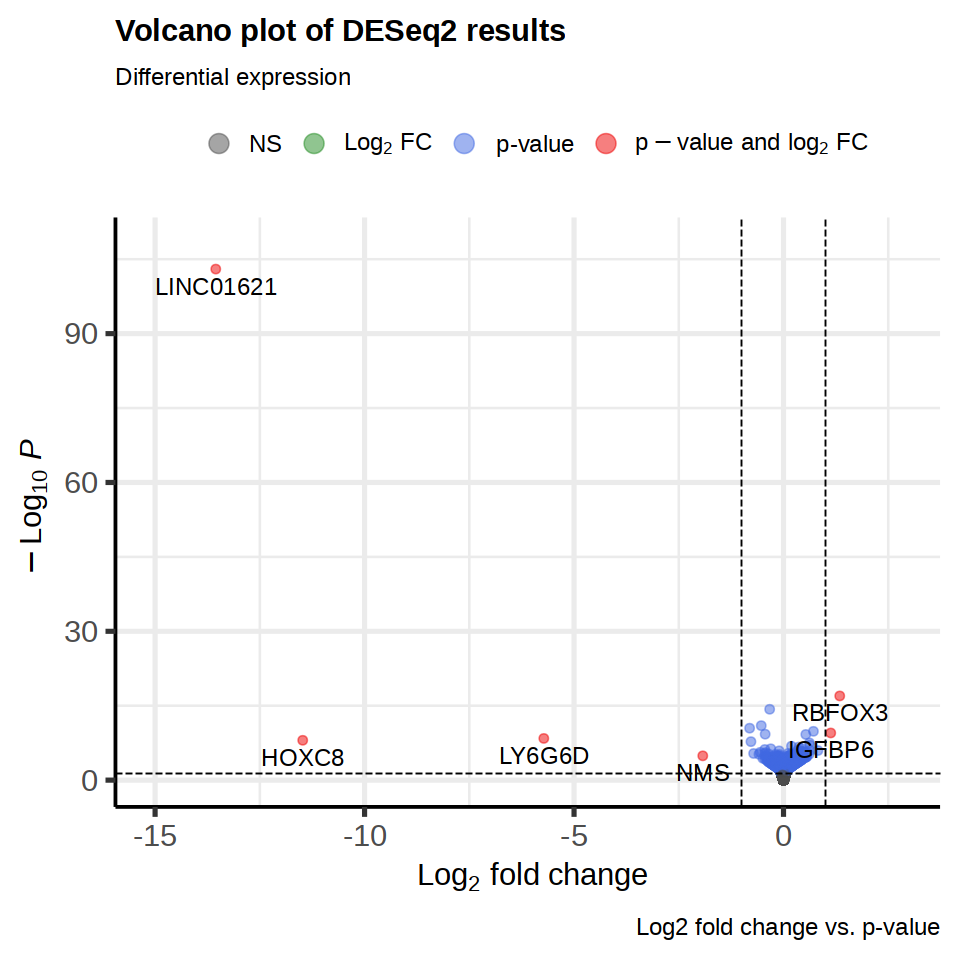

In [81]:
# Get results
res <- resAshT

options(repr.plot.width=8, repr.plot.height=8)

# Generate volcano plot
EnhancedVolcano(res,
                lab = rownames(res),
                x = 'log2FoldChange',
                y = 'pvalue',
                pCutoff = 0.05,
                FCcutoff = 1,
                title = 'Volcano plot of DESeq2 results',
                subtitle = 'Differential expression',
                caption = 'Log2 fold change vs. p-value')


In [93]:
table(vsd_l@colData$M_RA)


-0.247023184533617 -0.195228000679794  0.270928654004612   4.93249520084867 
               151                  8                 16                  7 

In [56]:
table(vsd@colData$M_RA)


-0.42279543647209 0.882246098889301  2.08895894809182  3.33725699238602 
              151                 8                16                 7 